## UGCA Group Assignment -2 

# Group Members
1. Chetna Singhal (cs57926)
2. David Kinman
3. Prajval Gupta
4. Subhayu Chakravarty
5. Whitt Hyde

In [1]:
#Import statements
import os
import re
# import tweepy as tw
import pandas as pd
import datetime
from string import punctuation
from bs4 import BeautifulSoup
import re
import nltk
from time import sleep
import copy
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from collections import Counter
from nltk import ngrams, FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, webtext
from sklearn import manifold
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sentiment
# from textblob import TextBlob
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/Users/prajvalgupta/.local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### PART A - Collecting tweets using Tweepy

In [ ]:
with open('secrets.txt', 'r') as file:
    data = file.read().split('\n')
    
consumer_key = data[0]
consumer_secret = data[1]
access_key = data[2]
access_secret = data[3]

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth,wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)

In [ ]:
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

In [ ]:
def get_query_tweets(query, num=0):
    num = 3000 if num > 3000 else num
    max_num_per_call = 100

    #authorize twitter, initialize tweepy
    auth = tw.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tw.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []    
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    curr_count = max_num_per_call if num > max_num_per_call else num
    num -= curr_count

    new_tweets = api.search(q=query, count=curr_count)
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    print(f"{len(alltweets)} tweets downloaded so far")

    #keep grabbing tweets until there are no tweets left to grab
    while num > 0:
        print(f"Getting tweets before {oldest}")
        
        curr_count = max_num_per_call if num > max_num_per_call else num

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.search(q=query, count=curr_count, max_id=oldest)
        num -= curr_count
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv    
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8"), tweet.user.location] for tweet in alltweets]
    df = pd.DataFrame(outtweets, columns=["id", "created_at", "text", "location"])
    #df.to_csv(f"query_{query}.csv", index=False)
    #print(df.head())
    return df

In [ ]:
# pass in the search query
new_search = "#2020Election" + " -filter:retweets"
tweets1 = get_query_tweets(new_search, 2000)
tweets2 = get_query_tweets("2020 U.S. election", 1000)
tweets3 = get_query_tweets("2020 presidential election", 1000)
new_search = "#election2020" + " -filter:retweets"
tweets4 = get_query_tweets(new_search, 2000)

In [ ]:
print(tweets1.shape,tweets2.shape,tweets3.shape,tweets4.shape)
tweets=tweets1.append(tweets2, ignore_index=True)
tweets=tweets.append(tweets3, ignore_index=True)
tweets=tweets.append(tweets4, ignore_index=True)
print(tweets.shape)
tweets.to_csv(r"tweets.csv",index=False)

### Data Cleaning

In [2]:
# Remove all punctuation characters from each tweet and convert text to lowercase for efficient frequency counting
# punctuation includes !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~

def remove_punctuations(item):
    for p in punctuation:
        item = item.strip().replace(p,'')
    return item

# Function to remove stopwords
def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 

In [3]:
# Load user comments into a dataframe
df = pd.read_csv("tweets.csv", usecols=["text"])
df.columns = ["Tweets"]

# Remove newline from each post & drop rows with null values
df = df.replace('\n','', regex=True)
df = df.dropna()

df["Tweet Length"]= df["Tweets"].str.len() 
df.head()

,Tweets,Tweet Length
0,b'No reparations no vote! No BLACK agenda no V...,72
1,b'Thoughts? San Francisco :: Adam Hattersley...,153
2,b'@TheJuanWilliams Why why why are you here???...,85
3,b'#BernieSanders = #Socialism which leads to #...,155
4,b'@AOC should re-think her endorsement of inde...,154


In [4]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner1(text):
    
    # HTML Decoding
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    souped = souped.replace("b", "", 1)
    # Remove URL links
    stripped = re.sub(pat2, '', souped)
    
    # UTF-8 BOM Decoding
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    
    # Remove hastags and numbers
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [5]:
clean_tweets = []

for i in range(df.shape[0]):
    clean_tweets.append(tweet_cleaner1(df['Tweets'][i]))
    
clean_tweets = pd.DataFrame(clean_tweets)
clean_tweets.columns = ["Tweets"]

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/prajvalgupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
clean_tweets["Tweets"] = clean_tweets['Tweets'].apply(remove_punctuations)

# Download stopwords
stop_words = set(stopwords.words('english'))

# Replace the typing errors and combine politician names mentioned differently
clean_tweets['Tweets'].replace({'realdonaldtrump':'trump', 'donaldtrump':'trump', 'donald':'trump', 'trumpxe':'trump', 'trumps':'trump', 'ntrump':'trump'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'elections':'election'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'presidential': 'president'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'democraticdebates':'demdebate','democraticdebate':'demdebate', 'demdebatemnthe ':'demdebate', 'cnndebate':'demdebate', 'demdebates':'demdebate','debates':'demdebate',' debate ': 'demdebate',}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'democratic ': 'democrats',  'thedemocrats ':'democrats', ' democrat ':'democrats', ' dem ':'democrats',}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'ewarren': 'warren',' elizabeth ': 'warren','elizabethwarren': 'warren','senwarren': 'warren' }, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'joebiden': 'biden',' joe ': 'biden'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({' bernie ': 'sanders','berniesanders': 'sanders', 'bernieyellsforus': 'sanders','stillsanders':'sanders'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'petebuttigieg': 'buttigieg',' pete ': 'buttigieg'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'andrewyang': 'yang',' andrew ': 'yang','yanggang': 'yang'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'kamalaharris': 'harris',' kamala ': 'harris'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'jobs':'job','factory':'job'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({' health ':'healthcare'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'russian':'russia'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'china':'trade'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'cyberwarfare':'russia'}, inplace=True, regex=True)

# Tokenize the posts
df['Tokens'] = clean_tweets['Tweets'].apply(word_tokenize).apply(set).apply(list)
df['Tokens'] = df['Tokens'].apply(remove_stopwords)
df["Tweets"] = df["Tweets"].apply(lambda x: x.lower())
df.head()

,Tweets,Tweet Length,Tokens
0,b'no reparations no vote! no black agenda no v...,72,"[vote, election, reparations, agenda, ados, bl..."
1,b'thoughts? san francisco :: adam hattersley...,153,"[x, hattersley, election, xa, thoughts, adamha..."
2,b'@thejuanwilliams why why why are you here???...,85,"[election, way, thejuanwilliams, trump]"
3,b'#berniesanders = #socialism which leads to #...,155,"[x, sanders, leads, government, dependency, so..."
4,b'@aoc should re-think her endorsement of inde...,154,"[x, sanders, ru, xe, lift, independent, republ..."


### PART B - Identifying 4 key issues mentioned in the tweets

In [8]:
count = []
# Count the frequency of the words
for i in range(len(df["Tokens"])):
    count += df.iloc[i]['Tokens']
count = [x.lower() for x in count]
word_freq = nltk.FreqDist(count)

# 500 most frequent words
top_words = word_freq.most_common(500)
top_words

[('x', 4391),
 ('xe', 4285),
 ('xa', 4160),
 ('election', 2759),
 ('trump', 1155),
 ('n', 987),
 ('president', 872),
 ('u', 835),
 ('demdebate', 785),
 ('rt', 691),
 ('warren', 450),
 ('biden', 330),
 ('new', 295),
 ('f', 290),
 ('trade', 282),
 ('via', 264),
 ('russia', 255),
 ('th', 252),
 ('war', 250),
 ('xf', 246),
 ('made', 244),
 ('democrats', 235),
 ('making', 234),
 ('months', 231),
 ('washington', 229),
 ('yang', 226),
 ('progress', 224),
 ('headlines', 221),
 ('polic', 220),
 ('tonight', 207),
 ('good', 195),
 ('report', 190),
 ('win', 189),
 ('candidates', 188),
 ('vote', 184),
 ('sanders', 180),
 ('secret', 178),
 ('people', 176),
 ('one', 175),
 ('know', 169),
 ('weapon', 169),
 ('buttigieg', 168),
 ('revealed', 168),
 ('like', 159),
 ('look', 158),
 ('cnn', 150),
 ('get', 148),
 ('think', 141),
 ('would', 141),
 ('candidate', 138),
 ('us', 137),
 ('need', 137),
 ('looks', 136),
 ('many', 129),
 ('maga', 127),
 ('amyklobuchar', 127),
 ('right', 126),
 ('years', 126),
 ('bi

### Analysis
Top Republican candidate - Donald Trump <br>
Top Democratic candidate - Elizabeth Warren <br><br>
Top 5 issues found:
1. Trade
2. Russia
3. Progress
4. Security
5. Job

### PART C.	Perform lift and sentiment analysis on a candidate and an issue:
To isolate a candidate and an issue, you have to write a parser that selects tweets that mention a candidate, takes a window around an issue, and chops off everything else, as shown in class.  


In [9]:
top_candidiate_count = []

unique_candidates = ['trump','warren']

for (key, items) in top_words:
    if key in unique_candidates:
        candidate_count = (key,items)
        top_candidiate_count.append(candidate_count)  

print ('Candidates we are exploring: \n' , top_candidiate_count[:10])

Candidates we are exploring: 
 [('trump', 1155), ('warren', 450)]


In [10]:
def issue_attri_count(issueList, df_a, attributeList):
    comb_count=[]
    car_count={}
    attrib_count={}
    for car in issueList:
        num_car=0
        for comment in df_a.Tweets:
                if car in comment:
                    num_car+=1
        car_count[car]=num_car
        for attrib in attributeList:
            num_combined=0
            num_attrib=0
            for comment in df_a.Tweets:
                if car in comment and attrib in comment:
                    num_combined+=1
                if attrib in comment:
                    num_attrib+=1
            attrib_count[attrib]=num_attrib
            comb_count.append(((car,attrib),num_combined))
    return [[car_count,attrib_count,comb_count]]

def calculate_lift(car, attrib, combined,attrib_count,car_count):
    if(attrib_count[attrib]==0):
        print(attrib)
    if(car_count[car]==0):
        print(car)
    lift = (4655*combined)/(car_count[car]*attrib_count[attrib])
    return lift

# Function to check if a issue is mentioned in a post or not
def issue_count(item):
    if issue in item:
        return 1
    else:
        return 0

In [11]:
attributeList = ['trump','warren','trade','russia','progress','security','job']
top_issues_count = []
for i,j in top_words:
    if i in attributeList:
        top_issues_count.append((i,j))

In [18]:
print("The Frequency count of the top 5 issues are: \n")
top_issues_count

The Frequency count of the top 5 issues are: 



[('trump', 1155),
 ('warren', 450),
 ('trade', 282),
 ('russia', 255),
 ('progress', 224),
 ('security', 109),
 ('job', 104)]

### Lift Matrix

In [19]:
top_issues =[]
for issue, count in top_issues_count:
    top_issues.append(issue) 

issue_df = pd.DataFrame(columns = top_issues)

for issue in top_issues:
    issue_df[issue] = df['Tokens'].apply(issue_count)        

lift_df = pd.DataFrame(columns = top_issues)

for i in range(len(top_issues)):
    new_list = []
    for j in range(len(top_issues)):
        if (i!=j):
            num = ((issue_df[top_issues[i]] + issue_df[top_issues[j]]) > 1).sum()
            dem = issue_df[top_issues[j]].sum()*issue_df[top_issues[i]].sum()
            lift = num * len(issue_df) / dem
            lift_df.loc[top_issues[i],top_issues[j]] = lift

lift_df = lift_df.replace(0,0.01)
print ('Lift Matrix:\n')
lift_df

Lift Matrix:



,trump,warren,trade,russia,progress,security,job
trump,NaN,0.668548,0.312692,0.325460,0.046313,0.190349,0.199500
warren,0.668548,NaN,0.094421,0.052209,0.010000,0.122141,7.680769
trade,0.312692,0.094421,NaN,0.083312,20.865312,0.010000,0.204276
russia,0.325460,0.052209,0.083312,NaN,0.010000,0.431085,0.010000
progress,0.046313,0.010000,20.865312,0.010000,NaN,0.010000,0.010000
security,0.190349,0.122141,0.010000,0.431085,0.010000,NaN,0.528493
job,0.199500,7.680769,0.204276,0.010000,0.010000,0.528493,NaN


### Sentiment

In [22]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/prajvalgupta/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
pair_list = lift_df[(lift_df.index == "trump") | (lift_df.index == "warren")].stack().index.tolist()
sorted_lifts = []
for index,column in pair_list:
    sorted_lifts.append(((index,column),lift_df[index][column]))
sorted_lifts.pop(0)
sorted_lifts.pop(5)

In [28]:
sorted_lifts_nt = []
sentiment_dict = {}
    
def sentiment_value(tweet):
    analyser = sentiment()
    result = analyser.polarity_scores(tweet)
    score = result['compound']
    return round(score,1)
count=0
for i in sorted_lifts:
    candidate = i[0][0]
    place = i[0][1]
    key = (candidate,place)
    sentiments = []
    for tweet in clean_tweets['Tweets']:
        if candidate in tweet and place in tweet:
            words = re.findall(r'\w+', tweet)
            if place in words:
                index = words.index(place)
                left = words[index - 3:index]
                right = words[index + 1:index + 4]
                tweetyy = " ".join(left) + " " + words[index] + " " + " ".join(right)
            else:
                tweetyy = tweet
            sv = sentiment_value(tweetyy)
            sentiments.append(sv)
#     print(sentiments)
    avg_sentiment = round(sum(sentiments)/len(sentiments),2)
    sentiment_dict[key] = avg_sentiment

print("Candidate  Issue  Sentiment")
sentiment_dict

Candidate  Issue  Sentiment


{('trump', 'trade'): 0.05,
 ('trump', 'russia'): 0.03,
 ('trump', 'progress'): 0.33,
 ('trump', 'security'): 0.25,
 ('trump', 'job'): 0.08,
 ('warren', 'trade'): 0.15,
 ('warren', 'russia'): 0.0,
 ('warren', 'progress'): -0.2,
 ('warren', 'security'): 0.3,
 ('warren', 'job'): -0.53}

<img src="Lift and Sentiment for Candidate-Issue.png" width="800"/>

## PART D - MDS Plot

In [30]:
# Calculating the dissimilarity matrix which is the input for plotting MDS plot

lift_inverse_df = 1/lift_df
np.fill_diagonal(lift_inverse_df.values, 0)

print ('Inverse Lift Matrix:\n')
lift_inverse_df

Inverse Lift Matrix:



,trump,warren,trade,russia,progress,security,job
trump,0.000000,1.495778,3.198032,3.072578,21.592389,5.253505,5.012519
warren,1.495778,0.000000,10.590886,19.153731,100.000000,8.187281,0.130195
trade,3.198032,10.590886,0.000000,12.003005,0.047926,100.000000,4.895343
russia,3.072578,19.153731,12.003005,0.000000,100.000000,2.319730,100.000000
progress,21.592389,100.000000,0.047926,100.000000,0.000000,100.000000,100.000000
security,5.253505,8.187281,100.000000,2.319730,100.000000,0.000000,1.892172
job,5.012519,0.130195,4.895343,100.000000,100.000000,1.892172,0.000000


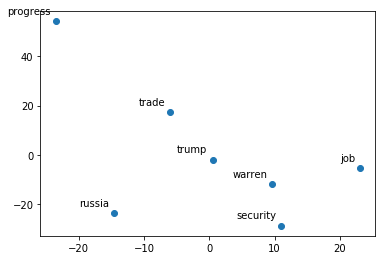

In [31]:
seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(lift_inverse_df)
coords = pos.embedding_


plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_issues, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-5, 5),
        textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.show()

## TASK E - Lift and Sentiment Analysis for the canditates in three states - Michigan, Pennsylvania and Wisconsin

In [39]:
df = pd.read_csv("tweets.csv")
# Remove newline from each post & drop rows with null values
df = df.replace('\n','', regex=True)
df = df.dropna().reset_index()
df.drop('index', axis=1, inplace=True)
df.head(5)
# Replacing State names with 'battleground' 
# Adding battlegrund number word inside tweet
for i in range(df.shape[0]):
    if df.loc[i,'location']:
        if 'MI' in df.loc[i,'location'].upper() or 'MICHIGAN' in df.loc[i,'location'].split(',') or 'MICHIGAN' in [x.strip() for x in df.loc[i,'location'].split(',')]:
            df.loc[i,'location']='battleground1'
            df.loc[i,'text']+=' '+'battleground1'+' '
        if 'PA' in df.loc[i,'location'].upper() or 'PENNSYLVANIA' in df.loc[i,'location'].split(',') or 'PENNSYLVANIA' in [x.strip() for x in df.loc[i,'location'].split(',')]:
            df.loc[i,'location']='battleground2'
            df.loc[i,'text']+=' '+'battleground2'+' '
        if 'WI' in df.loc[i,'location'].upper() or 'WISCONSIN' in df.loc[i,'location'].split(',') or 'WISCONSIN' in [x.strip() for x in df.loc[i,'location'].split(',')]:
            df.loc[i,'location']='battleground3'
            df.loc[i,'text']+=' '+'battleground3'+' '
df.tail(20)
df=df.rename(columns = {'text':'Tweets'})
def cand_state_count(brandList, df_a, attributeList):
    comb_count=[]
    car_count={}
    attrib_count={}
    for car in brandList:
        num_car=0
        for comment in df_a.Tweets:
              if car in comment.lower():
                    num_car+=1
        car_count[car]=num_car
        for attrib in attributeList:
            num_combined=0
            num_attrib=0
            for comment in df_a.Tweets:
                if car in comment.lower() and attrib in comment.lower():
                    num_combined+=1
                if attrib in comment.lower():
                    num_attrib+=1
            attrib_count[attrib]=num_attrib
            comb_count.append(((car,attrib),num_combined))
    return [[car_count,attrib_count,comb_count]]
def calculate_lift(car, attrib, combined, attrib_count, car_count):
    if(attrib_count[attrib]==0):
        print(attrib)
    if(car_count[car]==0):
        print(car)
    lift = (502*combined)/(car_count[car]*attrib_count[attrib])
    return lift
# Lifts of candidates with each state
candList = ['trump','warren']
statesList = ['battleground1','battleground2','battleground3']
# Lift scores for top 5 brands
lift_scores={}
df_a=df[df.location.str.startswith('battleground')]
for i in cand_state_count(candList, df_a, statesList):
    for k,num in i[2]:
        lift_scores[(k[0],k[1])] = calculate_lift(k[0],k[1], num,i[1],i[0])
sorted_lifts = sorted(lift_scores.items(), key=lambda kv: kv[1], reverse=True)
print("\n\nThe sorted Lift scores for three states are: \n")
for i in sorted_lifts:
    print(i)
sorted_lifts_nt = []
Sentiment_dict = {}
for i in sorted_lifts:
    tuple_ = i[0]
    sorted_lifts_nt.append(tuple_)
    Sentiment_dict[tuple_[0]+tuple_[1]]=[]
def sentiment_value(tweet):
    analyser = sentiment()
    result = analyser.polarity_scores(tweet)
    score = result['compound']
    return round(score,1)
count=0
time_line=[]
Sentiment_list = []
Key_list =[]
for i in sorted_lifts_nt:
    candidate = i[0]
    place = i[1]
    count += 1
    key = candidate + place
    key_space = candidate + ' ' +place
    Key_list.append(key_space)
    for tweet in df['Tweets']:
        if candidate in [x.strip().lower() for x in tweet.split(' ')] and place in [x.strip().lower() for x in tweet.split(' ')]:
            sv = sentiment_value(tweet)
            temp_list = []
            temp_list.append(key)
            temp_list.append(sv)
            Sentiment_dict[key].append(sv)
            Sentiment_list.append(temp_list)
            
print(Sentiment_dict)
Sentiment_states={}
for i in Sentiment_dict.keys():
    Sentiment_states[i]=round(np.array(Sentiment_dict[i]).mean(),2)

print("\n\nThe Sentiment scores for three states are: \n")
print(Sentiment_states)



The sorted Lift scores for three states are: 

(('warren', 'battleground3'), 1.5017094017094017)
(('trump', 'battleground3'), 1.1441595441595442)
(('warren', 'battleground2'), 1.1067019400352733)
(('trump', 'battleground2'), 1.0513668430335097)
(('trump', 'battleground1'), 0.8793793793793794)
(('warren', 'battleground1'), 0.6783783783783783)
{'warrenbattleground3': [-0.3, -0.5, 0.4, 0.3], 'trumpbattleground3': [0.0, -0.1, 0.0, 0.0, 0.0, 0.2, 0.6, 0.4, 0.4], 'warrenbattleground2': [0.6, 0.3, 0.0, 0.0, -0.5, 0.0, 0.4, 0.4, 0.4], 'trumpbattleground2': [0.0, -0.3, 0.5, 0.3, 0.0, -0.4, 0.0, 0.7, 1.0, 0.0, -0.5, 0.0, 0.0, 0.0, 0.2, 0.2, 0.6, 0.2, 0.2, -0.3, 0.0, 0.2, -0.3, -0.2, 0.2, -0.4], 'trumpbattleground1': [0.4, 0.6, 0.2, -0.4, 0.2, 0.6, 0.2, 0.2, 0.6, 0.4, 0.0, -0.4], 'warrenbattleground1': [0.4, 0.0]}


The Sentiment scores for three states are: 

{'warrenbattleground3': -0.03, 'trumpbattleground3': 0.17, 'warrenbattleground2': 0.18, 'trumpbattleground2': 0.07, 'trumpbattleground1'

<img src="Lif and Sentiment for Candidate - Battleground.png" width="800"/>

## TASK F - What advice would you give to each of the two candidates above based on your analyses in C, D and E above?

Based on the Lift Analysis above, both candidates (Trump and Warren) face the common goal of taking a clear lead in the political landscape. Our advice to both candidates is simple; you must break the deadlock and take the clear lead. Although this is easier said than done, we believe that the ultimate goal will be best assisted from gathering massive amounts of people’s real opinions on topics quickly. Twitter is the best forum for us to get such feedback while having libraries that enable us to scrape tweets from twitter users effectively. 

### TRUMP 

Trump has two major points based on our analysis from Twitter.

-	Trump’s sentiment for Progress is high 0.33 while having a moderate lift value of 0.04.
-	Trump’s Russia sentiment is at 0.03, but his lift value is moderately high for our analysis at 0.32.

First of all, Trump has done a successful job in progressing with the China Trade Deal, according to the Twittersphere. However, very few people are talking about the deal.<br>

-	“The U.S. China trade war has been making headlines for months now. Some progress has been made but, Washington Policy Analyst Ed Mills doesn’t foresee a broad resolution being reached in advance of the 2020 election.”<br>

This is why Trump has a high sentiment score with Progress. This result was the most surprising out of all the analysis we have done in our data set. The problem is no one seems to be talking about the major progress.<br>

Next, Trump is highly associated with Russia. This isn’t surprising, because this has been a major talking point for people on the other side of the aisle. However, what is surprising is the sentiment score is rather neutral, especially when you consider that there are more active users who have viewpoints more aligned with the democratic party. An example of a tweet that reduces the negative sentiment in his tweet.<br>
-	b'Dedicated to President Donald Trump #TrumpRussia, #USA, #2020Election, #Democracy, https://t.co/ejzysSBKv4'<br>

Overall, we recommend Trump to revise his policies on Russia/Putin because both sides of the aisle don’t view like his policies, and Russia is frequently associated with Trump. 



### WARREN

Warren is also struggling on the front of jobs and the trade war:

-	Warren’s sentiment for jobs is very low at -0.53, but the lift value is high at 7.68
-	Meanwhile, Warren has to improve her policy in trade because her campaign has a low sentiment value 0.15 and a lift score of 0.09.

Warren’s campaign is excelling on exposure and connection with jobs (she has a very high lift value of 7.68). However, she is not capitalizing to her fullest potential, as her sentiment is very low. She needs to convince America that she is a candidate who will be good for American jobs. We believe Warren’s low sentiment value is due to one tweet.<br>

-	“Warren is right, automation is not destroying as many factory jobs as people think” 

Looking at all of our tweets that have “Warren” and Jobs,” this tweet was 90% of results for that query. However, we still suggest that Warren layout to America her plans to create and maintain jobs. Any sort of effort to highlight this will be extremely effective as her lift is high. Thus, the campaign should spare no expense in advertising her stance on jobs to increase sentiment. Lastly, unusual about this sentiment score is we believe “destroying” is strongly pulling the sentiment below, despite Warren being “right.”<br>

In addition, Warren needs to adjust her stance on the Trade War. The trade war is among the top issues for the United States, and Americans remain unconvinced that Warren is the answer. With this in mind, we suggest at the next debate that Warren takes a firm stance (preferably the opposite of Trump’s as his sentiment is negative). By taking a strong stance, Warren will include her name in the trade war narrative, and thus will increase her lift value of 0.09. Finally, she needs to improve her sentiment value with trade. Our suggestion is to advertise Warren’s experience with economics and trade. If she can highlight why she is the right woman for the job, the sentiment is sure to follow. <br>

Tweet example:
1. Warren & Trade “Even I don’t buy #ElizabethWarren’s claim that bad #trade policies have been America’s main #jobs problem lately.\xe2\x80\xa6 https://t.co/AL4TFaDP47”



Overall, we recommend taking all of our recommendations with a grain of salt, because nearly all of our lift values are below one except Elizabeth Warren and Job‘s Lift Value. In addition, the only data point with a high lift value appears to be somewhat biased.


## BATTLEGROUND ADVICE

If we were advising either candidate, we would recommend gathering more data over a greater period to gain a data set with less variance. This improves the authenticity of your lift scores and sentiment values, especially when targeting specific states, which significantly reduces the relevant data compared to obtaining values from data across the United States. All of these states are known to have a vast working class who isn’t on social media, especially when compared to states like New York, California, or Florida. <br>

Lift scores often show candidates are associated with a topic, and how relevant are they to the discussion. For calculating the Lift Values with Candidates and battleground states, we were topic agnostic and calculated the lift value by candidate names in tweet and location of the tweet. In general, a higher lift value is positive. Lastly, if the lift value is below 1, we recommend both are candidates to take the sentiment value with a large grain of salt.<br>

### TRUMP 

#### Lift
Overall, all of the battleground states don’t have significant lift scores that are associated with Donald Trump. (Significance defines as a value over 1). However, Warren is talked about much more frequently than Donald Trump in all three battleground states. This contrasts President Trump’s presidential run in 2016 against Hillary Clinton. However, since we collected tweets from the last week on October 15th, so this is the best representation, due to the limited timeframe of collection. However, when Trump needs to start campaigning against Warren directly, we recommend that he should push more advertisements into those states.<br>

#### Sentiment
Overall, President Trump and Elizabeth Warren have very comparable Sentiment values within the battleground state. Both have a slightly positive sentiment. However, Trump has marginally better sentiment over Elizabeth Warren. However, there is still a lot of room for improvement. We recommend that Donald Trump replicate his success in the battleground states by continue promising for more industrial jobs/business for middle-class workers. <br>

### WARREN

#### Lift
Warren is doing an excellent job of being relevant to voters in the battleground states. Her lift values are incredibly high in Pennsylvania and Wisconsin, with a mediocre Michigan lift value. We find this very surprising because she hasn’t had campaign rallies or campaign events in Michigan, Pennsylvania, or Wisconsin in the last month.<br>

We believe all of this attention is coming from the 4th Democratic Primary debates, as per these tweets.
-	b'RT @voxdotcom: Warren is right, automation is not destroying as many factory jobs as people think #DemDebate https://t.co/QYKoSNVJHN' (Philadelphia)
-	"A sign of @EWarren's status as front-runner: midtier candidates like @PeteButtigieg and @AmyKlobuchar are attacking\xe2\x80\xa6 https://t.co/2f3584cZVi" (Flint, MI)

#### Sentiment

Overall, Warren has a slightly positive sentiment value and an effective neutral sentiment value in Wisconsin. It’s good that she doesn’t have a negative sentiment. However, she will likely need to have a greater sentiment value in the states than Trump, because Democrats tend to tweet far more frequently than Republicans. Also, I would assume
Luckily for Elizabeth Warren, she has a significant gap in her positive sentiment value between her and Trump in Pennsylvania, which is one of the largest states by electoral college count.<br>

#### Reference
The electoral college votes for the 2020 election in the battleground states are Wisconsin (10), Pennsylvania (20), and Michigan (16).
